In [1]:
#location of the data 
data_location =  "Flicker8k_Dataset/"
!ls $data_location

1000268201_693b08cb0e.jpg
1001773457_577c3a7d70.jpg
1002674143_1b742ab4b8.jpg
1003163366_44323f5815.jpg
1007129816_e794419615.jpg
1007320043_627395c3d8.jpg
1009434119_febe49276a.jpg
1012212859_01547e3f17.jpg
1015118661_980735411b.jpg
1015584366_dfcec3c85a.jpg
101654506_8eb26cfb60.jpg
101669240_b2d3e7f17b.jpg
1016887272_03199f49c4.jpg
1019077836_6fc9b15408.jpg
1019604187_d087bf9a5f.jpg
1020651753_06077ec457.jpg
1022454332_6af2c1449a.jpg
1022454428_b6b660a67b.jpg
1022975728_75515238d8.jpg
102351840_323e3de834.jpg
1024138940_f1fefbdce1.jpg
102455176_5f8ead62d5.jpg
1026685415_0431cbf574.jpg
1028205764_7e8df9a2ea.jpg
1030985833_b0902ea560.jpg
103106960_e8a41d64f8.jpg
103195344_5d2dc613a3.jpg
103205630_682ca7285b.jpg
1032122270_ea6f0beedb.jpg
1032460886_4a598ed535.jpg
1034276567_49bb87c51c.jpg
104136873_5b5d41be75.jpg
1042020065_fb3d3ba5ba.jpg
1042590306_95dea0916c.jpg
1045521051_108ebc19be.jpg
1048710776_bb5b0a5c7c.jpg
1052358063_eae6744153.jpg
105342180_4d4a40b47f.jpg
1053804096_ad278b25f1

In [2]:
#reading the text data 
import pandas as pd
caption_file = 'captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 40455 image to captions


C:\Users\EXTREME_RED\AppData\Local\Temp\ipykernel_24652\1027448185.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...


In [83]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import dgl.function as fn
from dgl.nn import GraphConv
import torchvision.models as models
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as f

In [5]:
#using spacy for the better text tokenization 
spacy_eng = spacy.load("en_core_web_sm")

In [6]:
class Vocabulary:
    def __init__(self,freq_threshold):

        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [8]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [10]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [15]:
#Helper function to plot the Tensor image
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [16]:
#Initiate the Dataset and Dataloader

#setting the constants
data_location =  "Flicker8k_Dataset/"
BATCH_SIZE = 32
# BATCH_SIZE = 6
NUM_WORKER = 4

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location,
    captions_file = "captions.txt",
    transform=transforms
)

#writing the dataloader
#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
    # batch_first=False
)

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
class EncoderCNN(nn.Module):
    def __init__(self, pretrained=True):
        super(EncoderCNN, self).__init__()
        
        # Load pre-trained VGG19 for feature extraction
        vgg = models.vgg19(pretrained=pretrained)
        for param in vgg.parameters():
            param.requires_grad_(False)
        self.vgg_features = vgg.features[:36]
        self.vgg_features = nn.Sequential(*self.vgg_features)
        
        # Load pre-trained Faster R-CNN for object detection
        self.detection_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        self.detection_model.eval()
        self.transform = T.Compose([
            T.ToTensor()
        ])
        
    def forward(self, images):
        features = self.vgg_features(images)  # (batch_size, 512, 14, 14)
        
        # Reshape the feature map
        features = features.view(features.size(0), -1, 49)  # (batch_size, 2048, 49)
        features = features.permute(0, 2, 1)  # (batch_size, 49, 2048)
        # Convert input PyTorch Tensors to PIL Images
        

        return features

In [77]:
class ObjectDetectorAndFeatureExtractor(nn.Module):
    def __init__(self, pretrained=True, iou_threshold=0.4):
        super(ObjectDetectorAndFeatureExtractor, self).__init__()
        
        # Load pre-trained Faster R-CNN for object detection
        self.object_detection_model = fasterrcnn_resnet50_fpn(pretrained=pretrained)
        self.object_detection_model.eval()
        
        # Load pre-trained VGG19 for feature extraction
        vgg = models.vgg19(pretrained=pretrained)
        for param in vgg.parameters():
            param.requires_grad_(False)
        self.feature_extractor = vgg.features[:36]
        self.feature_extractor = nn.Sequential(*self.feature_extractor)
        
        self.iou_threshold = iou_threshold
        
    def forward(self, images):
        graph_list = []
        
        for image in images:
            # Perform object detection
            with torch.no_grad():
                detections = self.object_detection_model([image])
            
            # Create a DGL graph for the image
            g = dgl.DGLGraph()
            
            # Check if no objects are detected
            if len(detections[0]['boxes']) == 0:
                # Add a node representing the entire image feature
                image_feature = self.feature_extractor(image.unsqueeze(0))
                image_feature = image_feature.view(image_feature.size(0), -1, 49)  # (batch_size, 2048, 49)
                image_feature = image_feature.permute(0, 2, 1)  # (batch_size, 49, 2048)
                g.add_nodes(1, {'features': image_feature})
                
                # Add self-loop edges to the node
                g.add_edges(0, 0)
                
                graph_list.append(g)
                continue
            
            # Add nodes for each detected object and assign features
            for i, detection in enumerate(detections):
                for box in detection['boxes']:
                    # Extract object region
                    object_region = image[:, int(box[1]):int(box[3]), int(box[0]):int(box[2])]
                    object_region = f.resize(object_region, (224, 224))  # Resize to a common size
                    
                    # Extract features using VGG19
                    features = self.feature_extractor(object_region.unsqueeze(0))
                    features = features.view(features.size(0), -1, 49)  # (batch_size, 2048, 49)
                    features = features.permute(0, 2, 1)  # (batch_size, 49, 2048)
                    
                    # Add node to the graph with object features
                    g.add_nodes(1, {'features': features})
            
            num_objects = g.number_of_nodes()
            
            # Add edges based on IoU between bounding boxes
            for i in range(num_objects):
                for j in range(num_objects):
                    if i != j:  # Skip adding self-edges
                        bbox_i = detections[0]['boxes'][i]
                        bbox_j = detections[0]['boxes'][j]
                        iou = self.calculate_iou(bbox_i, bbox_j)
                        if iou > self.iou_threshold:
                            g.add_edges(i, j)
            
            graph_list.append(g)
        
        return graph_list
    
    def calculate_iou(self, bbox1, bbox2):
        # Calculate intersection coordinates
        xmin = max(bbox1[0], bbox2[0])
        ymin = max(bbox1[1], bbox2[1])
        xmax = min(bbox1[2], bbox2[2])
        ymax = min(bbox1[3], bbox2[3])
        
        # Calculate intersection area
        intersection_area = max(0, xmax - xmin + 1) * max(0, ymax - ymin + 1)
        
        # Calculate union area
        area1 = (bbox1[2] - bbox1[0] + 1) * (bbox1[3] - bbox1[1] + 1)
        area2 = (bbox2[2] - bbox2[0] + 1) * (bbox2[3] - bbox2[1] + 1)
        union_area = area1 + area2 - intersection_area
        
        # Calculate IoU
        iou = intersection_area / union_area
        
        return iou


In [79]:

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        
        # Define GCN layers
        self.conv1 = GraphConv(in_feats, hidden_feats,allow_zero_in_degree=True)
        self.conv2 = GraphConv(hidden_feats, out_feats,allow_zero_in_degree=True)
        
        # Define linear layer for edge computation
        self.edge_linear = nn.Linear(in_feats * 2, in_feats)
        
    def forward(self, graph_list):
        output_list = []
        
        for g in graph_list:
            # Perform GCN on each graph in the list
            g = g.to(device)
            print(g)
            h = g.ndata['features']
            # Perform GCN
            h = self.conv1(g, h)
            h = torch.relu(h)
            h = self.conv2(g, h)
            # Compute edge values
            if g.number_of_edges() == 0 or g.number_of_nodes() == 1:
                output_list.append(h)
                continue
            
            # Concatenate src and dest node features for all edges
            src_feats = h[g.edges()[0]]
            print("src_feats feature after concat",src_feats.shape)
            dst_feats = h[g.edges()[1]]
            print("dst_feats feature after concat",dst_feats.shape)
            
            edge_feats = torch.cat([src_feats, dst_feats], dim=2)
            print("edge feature after concat",edge_feats.shape)
            # Compute edge values using a linear layer
            edge_values = self.edge_linear(edge_feats).squeeze(dim=1)
            g.edata['edge_values'] = edge_values
            print(edge_values.shape)

            
            output_list.append(edge_values)
        
        return output_list


In [22]:
"""#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights"""
        

'#Bahdanau Attention\nclass Attention(nn.Module):\n    def __init__(self, encoder_dim,decoder_dim,attention_dim):\n        super(Attention, self).__init__()\n        \n        self.attention_dim = attention_dim\n        \n        self.W = nn.Linear(decoder_dim,attention_dim)\n        self.U = nn.Linear(encoder_dim,attention_dim)\n        \n        self.A = nn.Linear(attention_dim,1)\n        \n        \n        \n        \n    def forward(self, features, hidden_state):\n        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)\n        w_ah = self.W(hidden_state) #(batch_size,attention_dim)\n        \n        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)\n        \n        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)\n        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)\n        \n        \n        alpha = F.softmax(attention_scores,dim=1)          #(batch_si

In [23]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_dim, num_heads, attention_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.attention_dim = attention_dim
        self.head_dim = attention_dim // num_heads

        self.linear = nn.Linear(input_dim, attention_dim)
        self.output_linear = nn.Linear(attention_dim, input_dim)

    def forward(self, inputs):
        batch_size, seq_length, input_dim = inputs.size()

        projected_inputs = self.linear(inputs)  # (batch_size, seq_length, attention_dim)
        
        projected_inputs = projected_inputs.view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_length, head_dim)

        energy = torch.matmul(projected_inputs, projected_inputs.transpose(-2, -1))  # (batch_size, num_heads, seq_length, seq_length)
        attention = F.softmax(energy / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32)), dim=-1)  # (batch_size, num_heads, seq_length, seq_length)

        context = torch.matmul(attention, projected_inputs).transpose(1, 2).contiguous().view(batch_size, seq_length, self.attention_dim)  # (batch_size, seq_length, attention_dim)
        # Reshape the attention tensor
        attention = attention.view(batch_size, self.num_heads * seq_length, seq_length)  # (batch_size, num_heads * seq_length, seq_length)
        attention = attention.permute(0, 2, 1)  # (batch_size, seq_length, num_heads * seq_length)
        output = self.output_linear(context)  # (batch_size, seq_length, input_dim)

        return output, attention


In [24]:
#Cross Attention
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, num_heads, attention_dim):
        super(MultiHeadCrossAttention, self).__init__()
        self.num_heads = num_heads
        self.attention_dim = attention_dim
        self.head_dim = attention_dim // num_heads

        self.encoder_linear = nn.Linear(encoder_dim, attention_dim)
        self.decoder_linear = nn.Linear(decoder_dim, attention_dim // num_heads)  # Adjusted dimension here
        self.output_linear = nn.Linear(attention_dim, decoder_dim)

    def forward(self, encoder_out, decoder_hidden):
        batch_size, num_features, _ = encoder_out.size()

        encoder_proj = self.encoder_linear(encoder_out)  # (batch_size, num_features, attention_dim)
        decoder_proj = self.decoder_linear(decoder_hidden)  # (batch_size, attention_dim // num_heads)

        encoder_proj = encoder_proj.view(batch_size, num_features, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, num_heads, num_features, head_dim)
        decoder_proj = decoder_proj.unsqueeze(1).unsqueeze(1)  # (batch_size, 1, 1, attention_dim // num_heads)

        energy = torch.matmul(encoder_proj, decoder_proj.transpose(-2, -1))  # (batch_size, num_heads, num_features, 1)
        attention = F.softmax(energy, dim=-2)  # (batch_size, num_heads, num_features, 1)

        context = torch.matmul(attention.transpose(-2, -1), encoder_proj).squeeze(-2)  # (batch_size, num_heads, head_dim)
        context = context.view(batch_size, self.head_dim * self.num_heads)  # (batch_size, attention_dim)

        output = self.output_linear(context)  # (batch_size, decoder_dim)

        return output, attention.squeeze(-1)


In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, num_heads, drop_prob=0.3):
        super().__init__()

        # Save the model parameters
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.num_heads = num_heads
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Multi-head cross attention
        self.attention = MultiHeadCrossAttention(encoder_dim, decoder_dim, num_heads, attention_dim)
        # Multi-head self-attention
        self.attention_self = MultiHeadSelfAttention(embed_size, num_heads, attention_dim)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size + decoder_dim, decoder_dim, bias=True)
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, encoder_out, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(encoder_out)

        seq_length = len(captions[0]) - 1  # Exclude the last one
        batch_size = captions.size(0)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(encoder_out.device)
        alphas = torch.zeros(batch_size, seq_length, encoder_out.size(1)).to(encoder_out.device)
        alphas_self = torch.zeros(batch_size, seq_length+1, self.num_heads*(seq_length+1)).to(encoder_out.device)

        for s in range(seq_length):
            # Multi-head self-attention over captions
            embeds_attended_self, alpha_self = self.attention_self(embeds)
            # Multi-head cross-attention with encoder output
            output, alpha = self.attention(encoder_out, h)

            lstm_input = torch.cat((embeds_attended_self[:, s], output), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            #print(alpha_self.shape)
            #alpha_self=alpha_self[:, s]
            #print(alpha_self.shape)
            preds[:, s] = output
            alphas[:, s] = alpha[:,-1,:]
            alphas_self[:,s] = alpha_self[:,s]

        return preds, alphas, alphas_self

    def generate_caption(self, encoder_out, max_len=20, vocab=None):
        batch_size = encoder_out.size(0)
        h, c = self.init_hidden_state(encoder_out)

        alphas = []
        alphas_self = []
        captions = []

        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(encoder_out.device)
        embeds = self.embedding(word)

        for i in range(max_len):
            embeds_attended_self, alpha_self = self.attention_self(embeds)
            alphas_self.append(alpha_self.cpu().detach().numpy())

            output, alpha = self.attention(encoder_out, h)
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeds_attended_self[:, 0], output), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)

            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())

            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        return [vocab.itos[idx] for idx in captions], alphas, alphas_self

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

In [80]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.obj_feature = ObjectDetectorAndFeatureExtractor()
        self.edge_feature = GCN(2048, 512, 2048)
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
            num_heads = 4
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        graphs = self.obj_feature(images)
        print(len(graphs))
        edge_features = self.edge_feature(graphs)
        #outputs = self.decoder(features, captions)
        print("whole image features shape",features.shape)
        
        print(len(edge_features))
        #print(graphs[0])
        #return outputs


In [28]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [81]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weigh

In [82]:
num_epochs = 25
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions_cross, attentions_self = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas,alphas_self = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()
        
    #save the latest model
    save_model(model,epoch)

c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


32
Graph(num_nodes=7, num_edges=10,
      ndata_schemes={'features': Scheme(shape=(49, 2048), dtype=torch.float32)}
      edata_schemes={})
src_feats feature after concat torch.Size([10, 49, 2048])
dst_feats feature after concat torch.Size([10, 49, 2048])
edge feature after concat torch.Size([10, 49, 4096])
torch.Size([10, 49, 2048])
Graph(num_nodes=9, num_edges=4,
      ndata_schemes={'features': Scheme(shape=(49, 2048), dtype=torch.float32)}
      edata_schemes={})
src_feats feature after concat torch.Size([4, 49, 2048])
dst_feats feature after concat torch.Size([4, 49, 2048])
edge feature after concat torch.Size([4, 49, 4096])
torch.Size([4, 49, 2048])
Graph(num_nodes=12, num_edges=78,
      ndata_schemes={'features': Scheme(shape=(49, 2048), dtype=torch.float32)}
      edata_schemes={})
src_feats feature after concat torch.Size([78, 49, 2048])
dst_feats feature after concat torch.Size([78, 49, 2048])
edge feature after concat torch.Size([78, 49, 4096])
torch.Size([78, 49, 2048])
Gr

TypeError: cannot unpack non-iterable NoneType object

## Test


In [ ]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas,alphas_self = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas, alphas_self

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

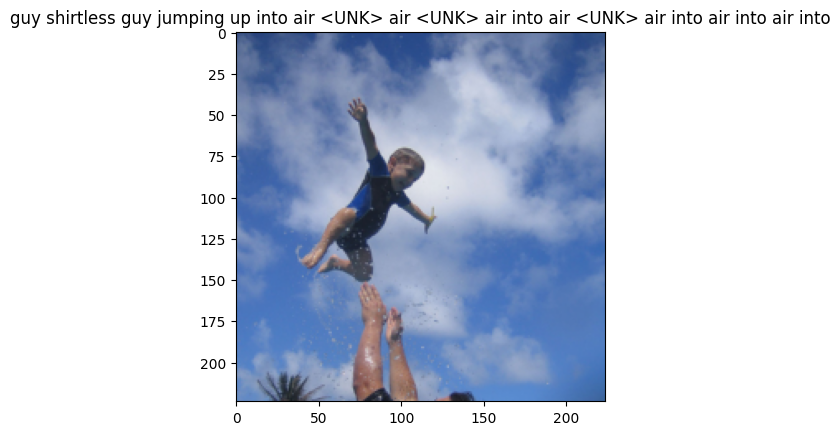

ValueError: cannot reshape array of size 196 into shape (7,7)

<Figure size 1500x1500 with 0 Axes>

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas,alphas_self = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

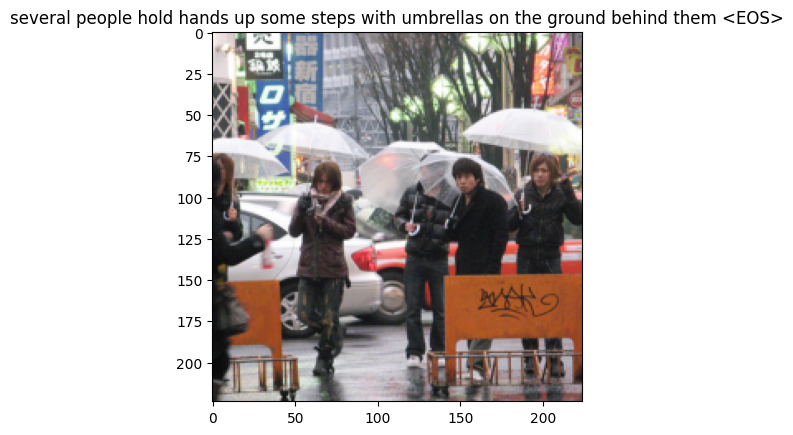

ValueError: too many values to unpack (expected 2)

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas,alphas_self)

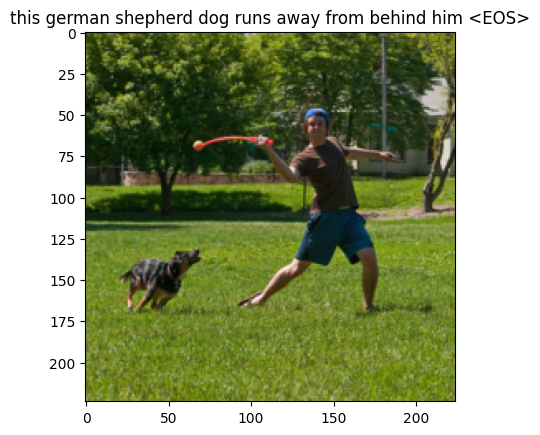

ValueError: too many values to unpack (expected 2)

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas,alphas_self)

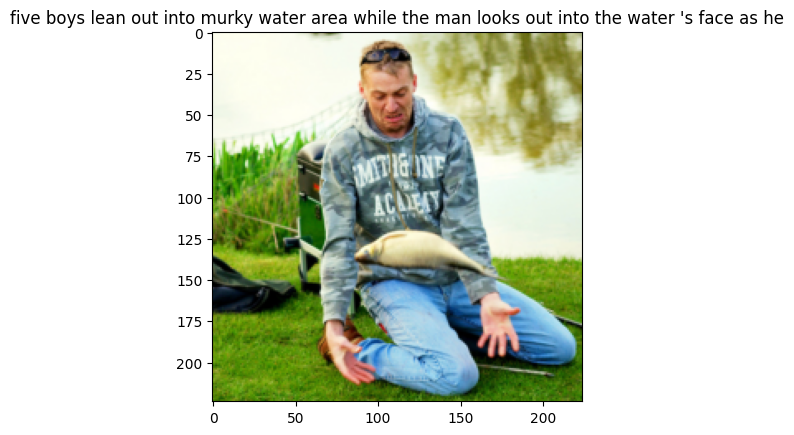

ValueError: too many values to unpack (expected 2)

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas,alphas_self)